# Energy efficiency at 11 degree

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pylab as plt
import delfi.distribution as dd
import time
from copy import deepcopy
import sys
sys.path.append("../setup")
sys.path.append("../simulator")
sys.path.append("../inference")
sys.path.append("../visualization")
sys.path.append('../thesis_figs')

from common import col, svg, samples_nd
import netio
import viz
import importlib
from compare_samples import get_dist, evaluate_summ_stats
import viz_samples
import viz_samples_thesis
import train_utils as tu
import startEndUtils as seu
from find_pyloric import merge_samples, params_are_bounded
import dill as pickle
from summstats_histogramms import plot_histogramm
from find_pyloric import merge_datasets, merge_datasets_energy, find_pyloric_like, find_close_to_obs

import matplotlib as mpl

date_today = '1908208'

%load_ext autoreload
%autoreload 2

### Load experimental data

In [3]:
summstats_experimental_11 = np.load('../thesis_results/experimental/summstats/857_016/ss_857_016_0049_11.npz')['summ_stats']
summstats_experimental_15 = np.load('../thesis_results/experimental/summstats/857_016/ss_857_016_0056_15.npz')['summ_stats']
summstats_experimental_19 = np.load('../thesis_results/experimental/summstats/857_016/ss_857_016_0059_19.npz')['summ_stats']
summstats_experimental_23 = np.load('../thesis_results/experimental/summstats/857_016/ss_857_016_0063_23.npz')['summ_stats']
summstats_experimental_27 = np.load('../thesis_results/experimental/summstats/857_016/ss_857_016_0069_27.npz')['summ_stats']

### Sort out the data from the cluster

In [4]:
filedir = '../results/energy/11deg/cluster/samples_more_ss'
dataset = None #'../results/samples/31D/R1/tmp_samples1.npz'
outfile = '../results/energy/11deg/cluster/samples11deg_more_ss.npz'
#merge_datasets_energy(filedir, dataset, outfile, exclude_NaN=True, enforce_pyloric=False, verbose=False)
print('--- Finished successfully ---')

--- Finished successfully ---


In [5]:
data_n = np.load(outfile)
sample_seed = data_n["seeds"]
print('There are', len(sample_seed), 'datapoints in this dataset')

There are 641233 datapoints in this dataset


In [81]:
filename = '../results/energy/11deg/cluster/samples11deg_more_ss.npz'
outfile  = '../results/energy/11deg/cluster/close_to_obs_more_ss.npz'
find_close_to_obs(filename, outfile, obs=summstats_experimental_11, num_stds=1.0)

In [82]:
data_n = np.load(outfile)
sample_seed = data_n["seeds"]
sample_params = data_n["params"]
sample_stats = data_n["stats"]
print('There are', len(sample_seed), 'datapoints in this dataset')

There are 149718 datapoints in this dataset


### Load setup

In [83]:
date_today = '190807'
import dill as pickle
with open('../thesis_results/temperature/nets/R1_11deg/191031_204070samples_seed1_Exper11deg_larger.pkl', 'rb') as file:
    inf_SNPE_MAF_11, log, params_11 = pickle.load(file)

In [84]:
prior_11 = netio.create_prior(params_11, log=True)
dimensions_11 = np.sum(params_11.use_membrane) + 7
lims_11 = np.asarray([-np.sqrt(3)*np.ones(dimensions_11), np.sqrt(3)*np.ones(dimensions_11)]).T

labels_ = viz.get_labels(params_11)
prior_normalized = dd.Uniform(-np.sqrt(3)*np.ones(dimensions_11), np.sqrt(3)*np.ones(dimensions_11), seed=params_11.seed)

params_11 = deepcopy(params_11)

params_mean_11 = prior_11.mean
params_std_11 = prior_11.std

params_11.model_params['temp'] = 283
pyloric_sim_11 = netio.create_simulators(params_11, save_all_energies=True)
energy_calc = netio.create_energy(params_11)

In [85]:
sample_params = (sample_params - params_mean_11) / params_std_11

In [86]:
npz = np.load('../results/experimental/traces/857_016/data_857_016_0056.npz')
t_15 = npz['t']

dt = t_15[1] - t_15[0]

# Plot posterior at 11 degree (after rejection sampling)

In [87]:
labels_ = viz.get_labels_8pt(params_11)
labels_[9] += ''

In [88]:
from decimal import Decimal
all_labels = []
lims=lims_11
params_std = params_std_11
params_mean = params_mean_11
for dim_i in range(31):
    if dim_i > len(params_mean_11) - 7.5: # synapses
        if dim_i == 24: all_labels.append([r'$\mathdefault{0.01}$     ', r'$\mathdefault{10000}\;\;\;\;$   '])
        else: all_labels.append([r'$\mathdefault{0.01}$ ', r'$\mathdefault{1000}\;\;\;\;$ '])
    else: # membrane conductances
        num_after_digits = -int(np.log10(lims[dim_i, 1] * params_std[dim_i] + params_mean[dim_i]))
        if num_after_digits > 2:
            num_after_digits=2
        labels = [round(Decimal((lims[dim_i, num_tmp] * params_std[dim_i] + params_mean[dim_i]) / 0.628e-3), num_after_digits)
                  for num_tmp in range(2)]
        new_labels = []
        counter=0
        for l in labels:
            if counter == 0:
                new_labels.append(r'$\mathdefault{'+str(l)+'}$  ')
            else:
                new_labels.append(r'$\mathdefault{'+str(l)+'}\;\;\;$  ')
            counter+=1
        all_labels.append(new_labels)

In [89]:
prior_sample_unnorm = np.load('../thesis_results/samples/bad_prior_sample/prior_sample2.npz')['prior_sample']
prior_sample_norm = (prior_sample_unnorm - params_mean) / params_std

In [90]:
sample_params = data_n["params"]
sample_stats = data_n["stats"]
print('There are', len(sample_seed), 'datapoints in this dataset')

There are 149718 datapoints in this dataset


In [91]:
sample_params = (sample_params - params_mean_11) / params_std_11

# Find most efficient neurons

In [183]:
sample_params = data_n["params"]
sample_stats = data_n["stats"]
sample_seeds = data_n["seeds"]

### Find three most efficient AB/PD neurons

In [184]:
max_energy_allowed = 45000
energies = sample_stats[:, -3:]
summed_energies = energies[:, 0]
sample_params_ABPD = sample_params[summed_energies < max_energy_allowed]
sample_seeds_ABPD = sample_seeds[summed_energies < max_energy_allowed]
print(sample_params_ABPD.shape)

(3, 31)


### Find three most efficient LP neurons

In [185]:
max_energy_allowed = 51000
energies = sample_stats[:, -3:]
summed_energies = energies[:, 1]
sample_params_LP = sample_params[summed_energies < max_energy_allowed]
sample_seeds_LP = sample_seeds[summed_energies < max_energy_allowed]
print(sample_params_LP.shape)

(3, 31)


### Find three most efficient PY neurons

In [186]:
max_energy_allowed = 200000
energies = sample_stats[:, -3:]
summed_energies = energies[:, 2]
sample_params_PY = sample_params[summed_energies < max_energy_allowed]
sample_seeds_PY = sample_seeds[summed_energies < max_energy_allowed]
print(sample_params_LP.shape)

(3, 31)


# Build a pyloric network with combinations of these neurons

In [170]:
indices = np.random.permutation(3)
syn_index = np.random.randint(0, 3, 1) # three neurons and synapses, so we draw four indices
print(indices)

[2 1 0]


In [172]:
syn_index

array([0])

### Pick a synapse setting at random
We pick a setting of any of the three neurons we have

In [173]:
if syn_index[0] == 0:
    syn_params = sample_params_ABPD[indices[0], 24:]
if syn_index[0] == 1:
    syn_params = sample_params_LP[indices[0], 24:]
if syn_index[0] == 2:
    syn_params = sample_params_PY[indices[0], 24:]

In [174]:
comb_params = np.concatenate((sample_params_ABPD[indices[0], :8], sample_params_ABPD[indices[1], 8:16], sample_params_ABPD[indices[2], 16:24], syn_params))

In [175]:
sample_params = comb_params

In [176]:
sample_params

array([ 3.35746629e-02,  5.87415796e-04,  5.23237912e-04,  7.44789000e-03,
        1.30940515e-03,  8.33322368e-02,  1.11511378e-05,  2.38772220e-06,
        6.94817231e-02,  6.26768380e-04,  2.12147766e-03,  2.41197969e-02,
        6.90861441e-04,  6.22694578e-02,  1.36897735e-05,  1.27036633e-05,
        2.26856097e-01,  5.82070768e-03,  1.08986364e-03,  2.86225286e-02,
        1.13123808e-04,  6.76746460e-02,  2.65242757e-05,  9.76496903e-06,
       -1.52777230e+01, -9.62342021e+00, -1.39490890e+01, -8.58089632e+00,
       -9.69998956e+00, -1.46177581e+01, -7.69441820e+00])

In [177]:
import importlib
from copy import deepcopy
import matplotlib.gridspec as gridspec

pyloric_sim = pyloric_sim_11
summ_stats = energy_calc

offsets = [150000, 95000, 100000, 100000, 100000, 100000, 100000, 40000, 40000, 40000, 40000, 40000, 40000]


scale_bar_ = [False, False]
all_outs = []
counter = 0
all_counter = 0
target_params = deepcopy(sample_params)
print('all_counter', all_counter)

out_target = pyloric_sim[0].gen_single(deepcopy(target_params), seed_sim=True, to_seed=0) # params.true_params gives the synaptic strengths #  165000

all_counter 0


(13,)


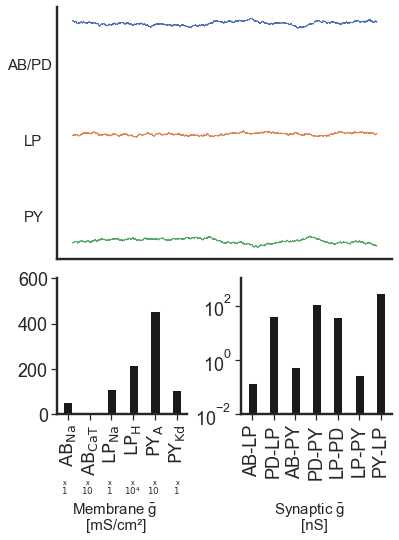

In [178]:
fig = viz_samples.vis_sample(pyloric_sim[0], summ_stats, target_params, voltage_trace=out_target, test_idx=[0], case='high_p', hyperparams=params_11, offset_labels=1000, with_ss=False, time_len=115000, fontscale=1.2, linescale=1.2, legend=False, offset=offsets[all_counter],
                             mode='31D', mem_dimensions=[0,1,8,14,19,21], title='Sample along the path of high probability in Prinz format', date_today='190906_31D_samples_small', counter=counter, mode2='small', scale_bar=False, save_fig=False)
plt.show()

# Loop over this whole thing

In [199]:
import importlib
from copy import deepcopy
import matplotlib.gridspec as gridspec

In [200]:
all_targets = []

for _ in range(10):
    indices = np.random.permutation(3)
    syn_index = np.random.randint(0, 3, 1) # three neurons and synapses, so we draw four indices
    print(indices, syn_index)    
    
    if syn_index[0] == 0:
        syn_params = sample_params_ABPD[indices[0], 24:]
    if syn_index[0] == 1:
        syn_params = sample_params_LP[indices[0], 24:]
    if syn_index[0] == 2:
        syn_params = sample_params_PY[indices[0], 24:]
        
    comb_params = np.concatenate((sample_params_ABPD[indices[0], :8], sample_params_LP[indices[1], 8:16], sample_params_PY[indices[2], 16:24], syn_params))
    
    sample_params = comb_params

    pyloric_sim = pyloric_sim_11
    summ_stats = energy_calc

    offsets = [150000, 95000, 100000, 100000, 100000, 100000, 100000, 40000, 40000, 40000, 40000, 40000, 40000]


    scale_bar_ = [False, False]
    all_outs = []
    counter = 0
    all_counter = 0
    target_params = deepcopy(sample_params)
    print('all_counter', all_counter)

    out_target = pyloric_sim[0].gen_single(deepcopy(target_params), seed_sim=True, to_seed=0) # params.true_params gives the synaptic strengths #  165000
    
    all_targets.append(out_target)

[2 0 1] [1]
all_counter 0
[1 2 0] [1]
all_counter 0
[2 0 1] [2]
all_counter 0
[1 2 0] [2]
all_counter 0
[2 1 0] [0]
all_counter 0
[2 0 1] [0]
all_counter 0
[0 1 2] [0]
all_counter 0
[0 1 2] [0]
all_counter 0
[1 2 0] [1]
all_counter 0
[1 2 0] [2]
all_counter 0


In [205]:
counter = 0
for out_target in all_targets:
    energy = out_target['energy']
    print(counter, 'summed energy is:   ', np.sum(energy))
    counter += 1

0 summed energy is:    65270.900471864734
1 summed energy is:    36132.40216603874
2 summed energy is:    68321.71258095322
3 summed energy is:    51419.99477270856
4 summed energy is:    14350.4055188545
5 summed energy is:    43531.15587308654
6 summed energy is:    27992.61630965416
7 summed energy is:    28905.687655443715
8 summed energy is:    49834.34167632606
9 summed energy is:    48828.689471954254


counter 0
(13,)


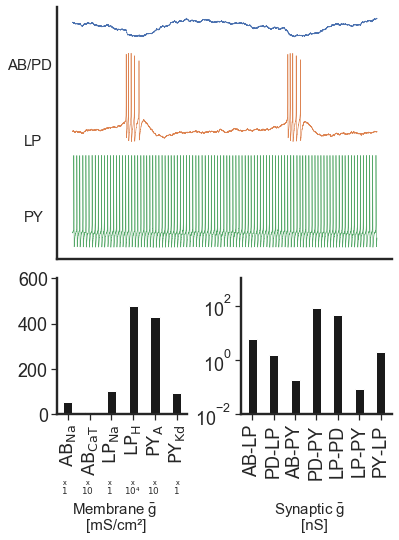

counter 1
(13,)


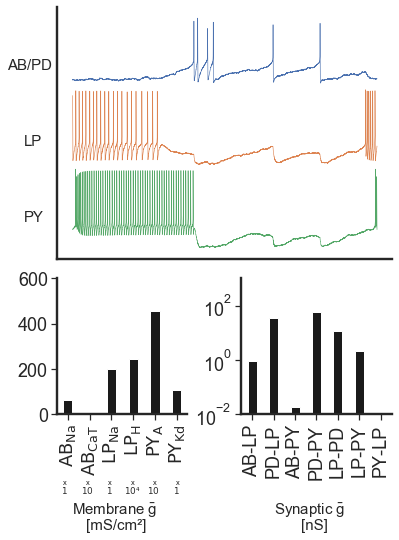

counter 2
(13,)


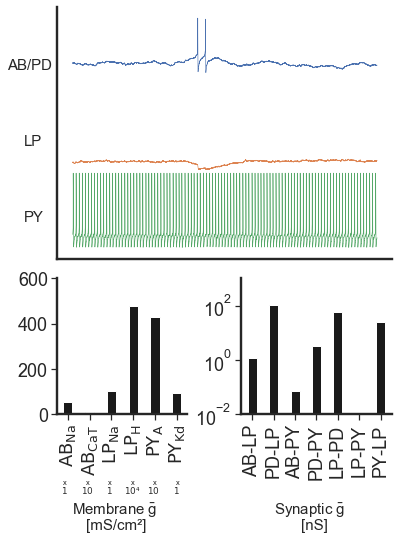

counter 3
(13,)


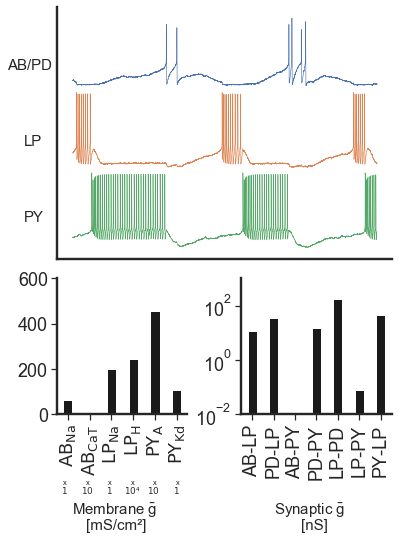

counter 4
(13,)


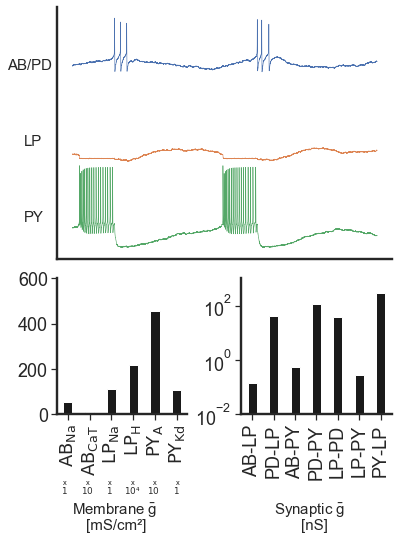

counter 5
(13,)


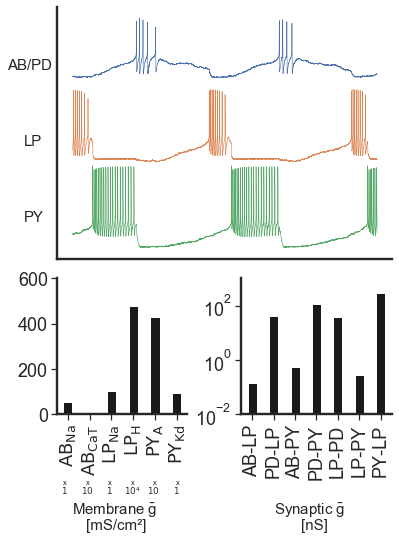

counter 6
(13,)


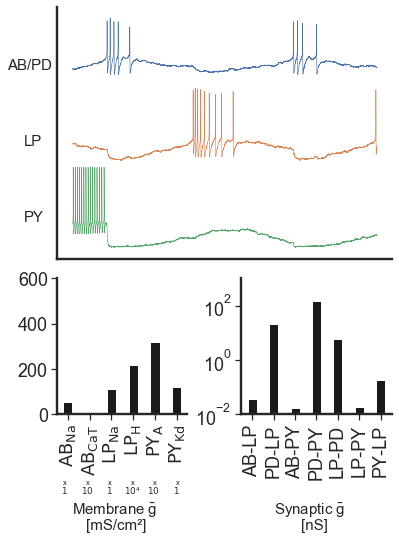

counter 7
(13,)


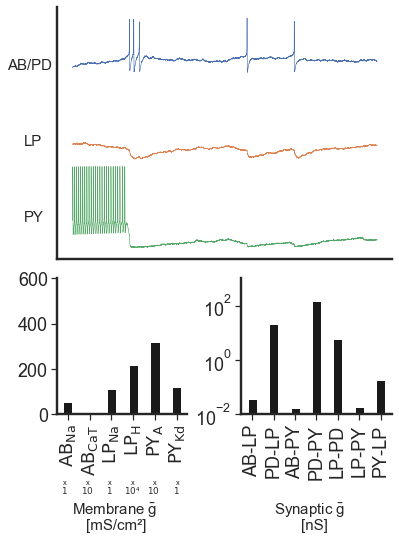

counter 8
(13,)


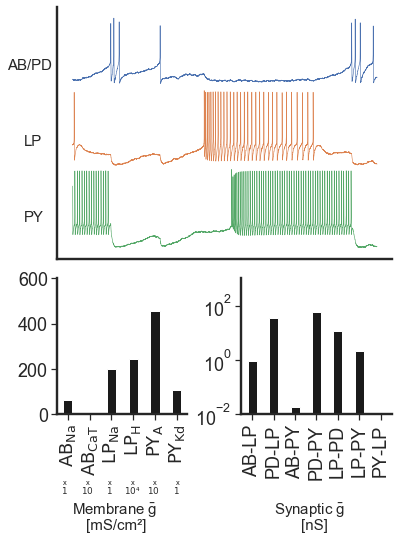

counter 9
(13,)


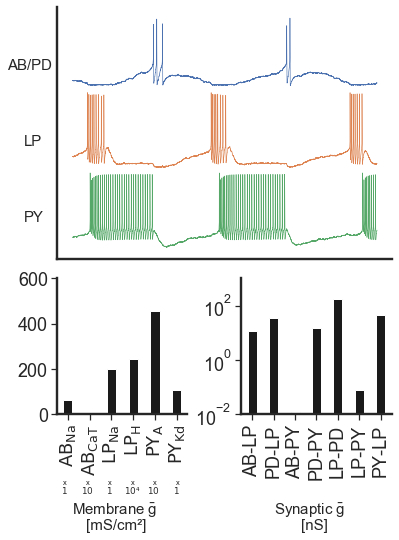

In [203]:
counter = 0
for out_target in all_targets:
    print('counter', counter)
    fig = viz_samples.vis_sample(pyloric_sim[0], summ_stats, target_params, voltage_trace=out_target, test_idx=[0], case='high_p', hyperparams=params_11, offset_labels=1000, with_ss=False, time_len=115000, fontscale=1.2, linescale=1.2, legend=False, offset=offsets[all_counter],
                                 mode='31D', mem_dimensions=[0,1,8,14,19,21], title='Sample along the path of high probability in Prinz format', date_today='190906_31D_samples_small', counter=counter, mode2='small', scale_bar=False, save_fig=False)
    plt.show()
    counter += 1

# Show baseline samples

### AB/PD neuron

In [219]:
all_targets_base = []

for k in range(3):  
    comb_params = sample_params_ABPD[k]
    
    sample_params = comb_params

    pyloric_sim = pyloric_sim_11
    summ_stats = energy_calc

    offsets = [150000, 95000, 100000, 100000, 100000, 100000, 100000, 40000, 40000, 40000, 40000, 40000, 40000]


    scale_bar_ = [False, False]
    all_outs = []
    counter = 0
    all_counter = 0
    target_params = deepcopy(sample_params)
    print('all_counter', all_counter)
    
    out_target = pyloric_sim[0].gen_single(deepcopy(target_params), seed_sim=True, to_seed=sample_seeds_ABPD[k]) # params.true_params gives the synaptic strengths #  165000
    
    all_targets_base.append(out_target)

all_counter 0
all_counter 0
all_counter 0


In [222]:
counter = 0
for out_target in all_targets_base:
    energy = out_target['energy']
    print(counter, 'summed energy is:   ', np.sum(energy))
    counter += 1

0 summed energy is:    32741.86282162948
1 summed energy is:    39148.41804848393
2 summed energy is:    48099.23240326


counter 0
(13,)


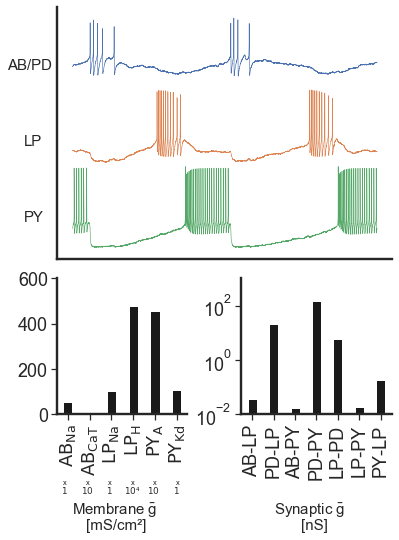

counter 1
(13,)


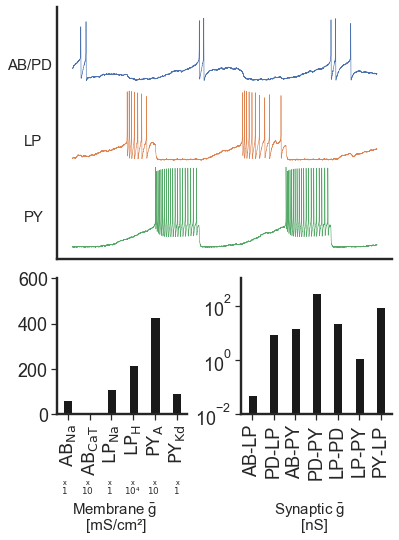

counter 2
(13,)


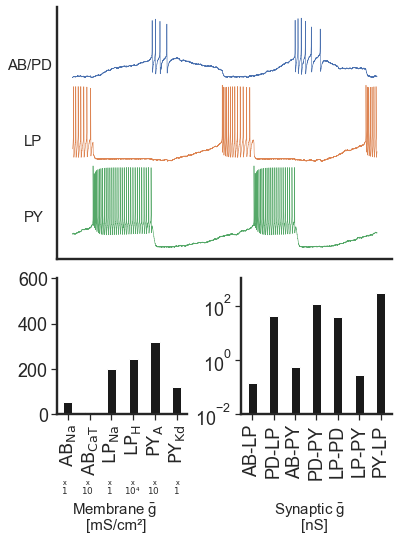

In [223]:
counter = 0
for out_target in all_targets_base:
    print('counter', counter)
    fig = viz_samples.vis_sample(pyloric_sim[0], summ_stats, target_params, voltage_trace=out_target, test_idx=[0], case='high_p', hyperparams=params_11, offset_labels=1000, with_ss=False, time_len=115000, fontscale=1.2, linescale=1.2, legend=False, offset=offsets[all_counter],
                                 mode='31D', mem_dimensions=[0,1,8,14,19,21], title='Sample along the path of high probability in Prinz format', date_today='190906_31D_samples_small', counter=counter, mode2='small', scale_bar=False, save_fig=False)
    plt.show()
    counter += 1

### LP neuron

In [224]:
all_targets_base = []

for k in range(3):  
    comb_params = sample_params_LP[k]
    
    sample_params = comb_params

    pyloric_sim = pyloric_sim_11
    summ_stats = energy_calc

    offsets = [150000, 95000, 100000, 100000, 100000, 100000, 100000, 40000, 40000, 40000, 40000, 40000, 40000]

    scale_bar_ = [False, False]
    all_outs = []
    counter = 0
    all_counter = 0
    target_params = deepcopy(sample_params)
    print('all_counter', all_counter)
    
    out_target = pyloric_sim[0].gen_single(deepcopy(target_params), seed_sim=True, to_seed=sample_seeds_LP[k]) # params.true_params gives the synaptic strengths #  165000
    
    all_targets_base.append(out_target)

all_counter 0
all_counter 0
all_counter 0


In [225]:
counter = 0
for out_target in all_targets_base:
    energy = out_target['energy']
    print(counter, 'summed energy is:   ', np.sum(energy))
    counter += 1

0 summed energy is:    77465.68534060723
1 summed energy is:    33046.05268834672
2 summed energy is:    35702.19447285653


counter 0
(13,)


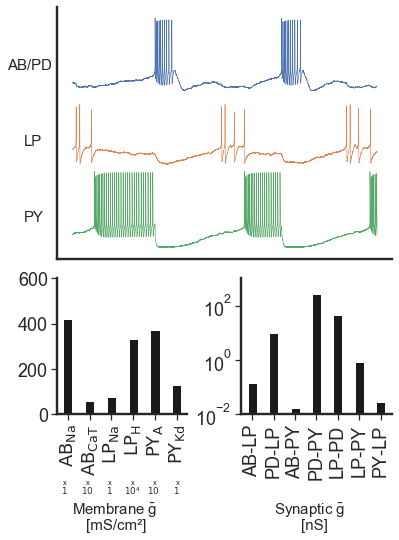

counter 1
(13,)


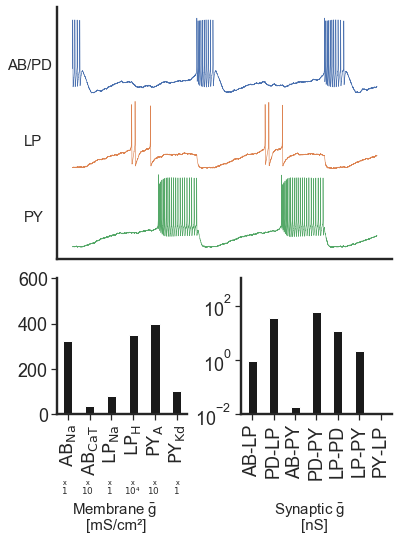

counter 2
(13,)


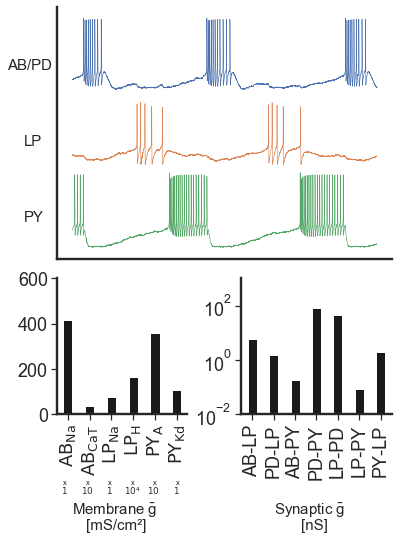

In [226]:
counter = 0
for out_target in all_targets_base:
    print('counter', counter)
    fig = viz_samples.vis_sample(pyloric_sim[0], summ_stats, target_params, voltage_trace=out_target, test_idx=[0], case='high_p', hyperparams=params_11, offset_labels=1000, with_ss=False, time_len=115000, fontscale=1.2, linescale=1.2, legend=False, offset=offsets[all_counter],
                                 mode='31D', mem_dimensions=[0,1,8,14,19,21], title='Sample along the path of high probability in Prinz format', date_today='190906_31D_samples_small', counter=counter, mode2='small', scale_bar=False, save_fig=False)
    plt.show()
    counter += 1

### PY neuron

In [227]:
all_targets_base = []

for k in range(3):  
    comb_params = sample_params_PY[k]
    
    sample_params = comb_params

    pyloric_sim = pyloric_sim_11
    summ_stats = energy_calc

    offsets = [150000, 95000, 100000, 100000, 100000, 100000, 100000, 40000, 40000, 40000, 40000, 40000, 40000]

    scale_bar_ = [False, False]
    all_outs = []
    counter = 0
    all_counter = 0
    target_params = deepcopy(sample_params)
    print('all_counter', all_counter)
    
    out_target = pyloric_sim[0].gen_single(deepcopy(target_params), seed_sim=True, to_seed=sample_seeds_PY[k]) # params.true_params gives the synaptic strengths #  165000
    
    all_targets_base.append(out_target)

all_counter 0
all_counter 0
all_counter 0


In [228]:
counter = 0
for out_target in all_targets_base:
    energy = out_target['energy']
    print(counter, 'summed energy is:   ', np.sum(energy))
    counter += 1

0 summed energy is:    21117.03450510097
1 summed energy is:    33929.24979604508
2 summed energy is:    40510.50381202195


counter 0
(13,)


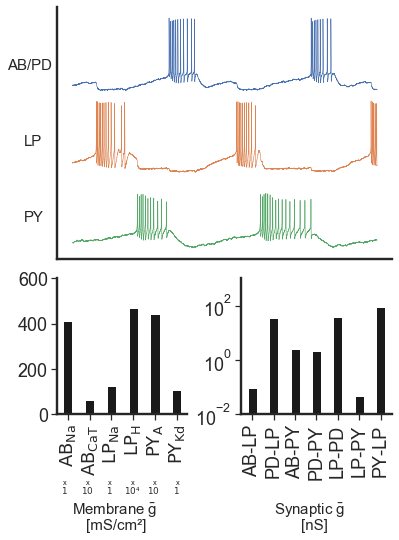

counter 1
(13,)


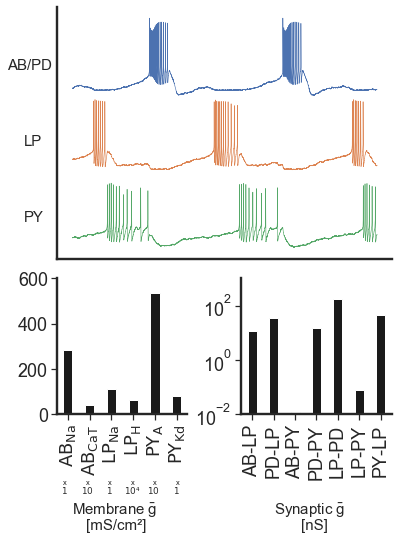

counter 2
(13,)


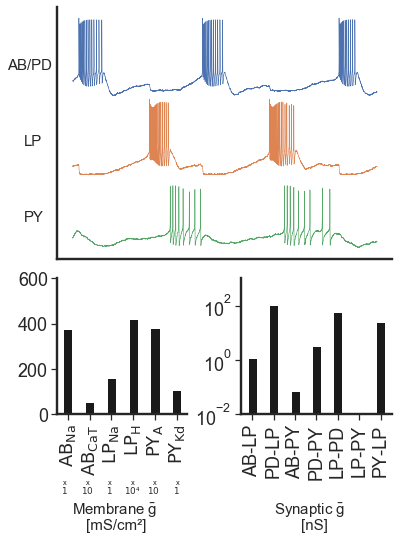

In [229]:
counter = 0
for out_target in all_targets_base:
    print('counter', counter)
    fig = viz_samples.vis_sample(pyloric_sim[0], summ_stats, target_params, voltage_trace=out_target, test_idx=[0], case='high_p', hyperparams=params_11, offset_labels=1000, with_ss=False, time_len=115000, fontscale=1.2, linescale=1.2, legend=False, offset=offsets[all_counter],
                                 mode='31D', mem_dimensions=[0,1,8,14,19,21], title='Sample along the path of high probability in Prinz format', date_today='190906_31D_samples_small', counter=counter, mode2='small', scale_bar=False, save_fig=False)
    plt.show()
    counter += 1

### Show the circuits are very most energy efficient

In [247]:
sample_params = data_n["params"]
sample_stats = data_n["stats"]
sample_seeds = data_n["seeds"]

In [248]:
max_energy_allowed = 850000
energies = sample_stats[:, -3:]
summed_energies = np.sum(energies, axis=1)
sample_params_total = sample_params[summed_energies < max_energy_allowed]
sample_seeds_total = sample_seeds[summed_energies < max_energy_allowed]
print(sample_seeds_total.shape)

(5,)


In [249]:
all_targets_base = []

for k in range(5):  
    comb_params = sample_params_total[k]
    
    sample_params = comb_params

    pyloric_sim = pyloric_sim_11
    summ_stats = energy_calc

    offsets = [150000, 95000, 100000, 100000, 100000, 100000, 100000, 40000, 40000, 40000, 40000, 40000, 40000]

    scale_bar_ = [False, False]
    all_outs = []
    counter = 0
    all_counter = 0
    target_params = deepcopy(sample_params)
    print('all_counter', all_counter)
    
    out_target = pyloric_sim[0].gen_single(deepcopy(target_params), seed_sim=True, to_seed=sample_seeds_total[k]) # params.true_params gives the synaptic strengths #  165000
    
    all_targets_base.append(out_target)

all_counter 0
all_counter 0
all_counter 0
all_counter 0
all_counter 0


In [250]:
counter = 0
for out_target in all_targets_base:
    energy = out_target['energy']
    print(counter, 'summed energy is:   ', np.sum(energy))
    counter += 1

0 summed energy is:    13300.1489135565
1 summed energy is:    12227.66515310351
2 summed energy is:    13243.339443806812
3 summed energy is:    12677.67680307677
4 summed energy is:    13406.930374158048


counter 0
(13,)


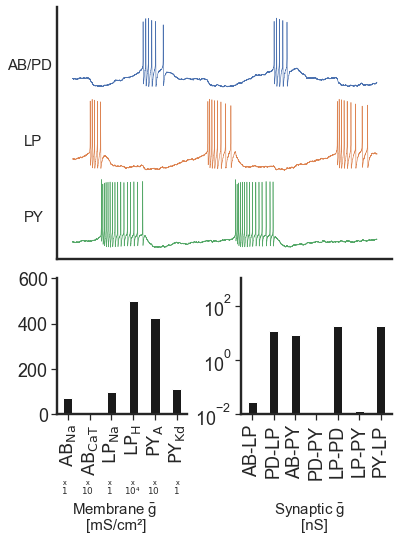

counter 1
(13,)


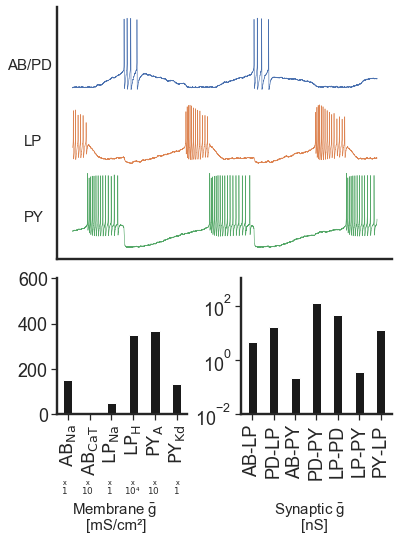

counter 2
(13,)


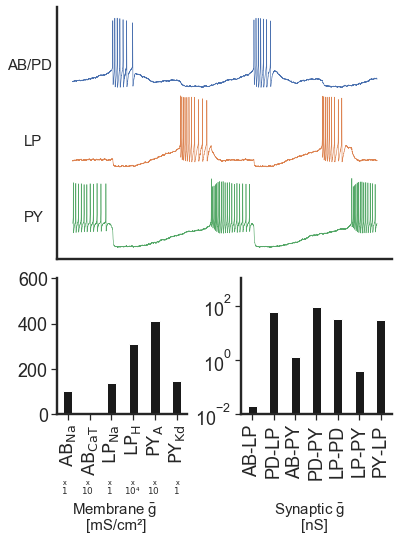

counter 3
(13,)


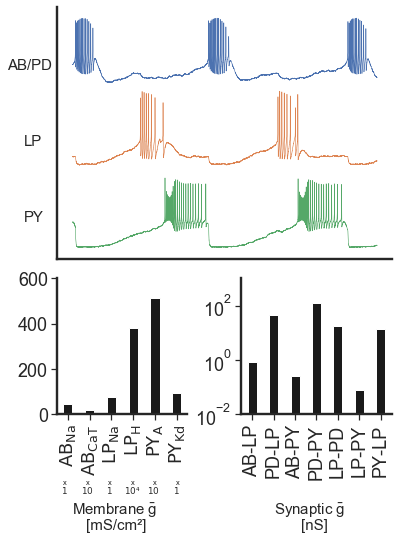

counter 4
(13,)


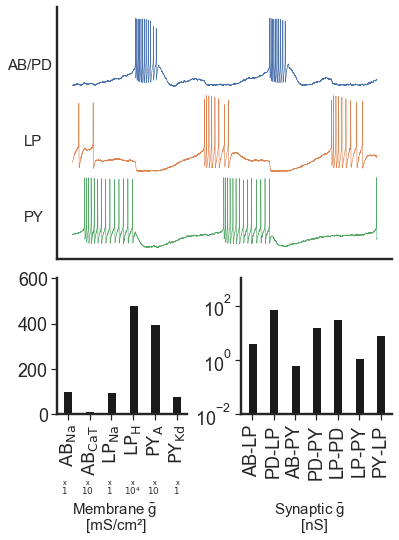

In [251]:
counter = 0
for out_target in all_targets_base:
    print('counter', counter)
    fig = viz_samples.vis_sample(pyloric_sim[0], summ_stats, target_params, voltage_trace=out_target, test_idx=[0], case='high_p', hyperparams=params_11, offset_labels=1000, with_ss=False, time_len=115000, fontscale=1.2, linescale=1.2, legend=False, offset=offsets[all_counter],
                                 mode='31D', mem_dimensions=[0,1,8,14,19,21], title='Sample along the path of high probability in Prinz format', date_today='190906_31D_samples_small', counter=counter, mode2='small', scale_bar=False, save_fig=False)
    plt.show()
    counter += 1